# **PRÁCTICA 4 - BICIMAD**

---



Claudia Casado Poyatos

Natalia García Domínguez

Olga Rodríguez Acevedo

# **Motivación**
BiciMAD surge como un nuevo medio de transporte en la ciudad de Madrid, un servicio público de bicicletas que favorece el movimiento de los ciudadanos de manera sostenible para el medio ambiente. Actualmente la ciudad posee 2.964 bicicletas, 6.315 anclajes y 264 estaciones repartidas por toda la ciudad, las cuáles se pueden consultar mediante la app de BiciMAD. 
Como base de datos usaremos el mes de **mayo de 2021**, ya que en este mes finalizó la prórroga del estado de alarma debido al COVID-19 y se eliminaron muchas de las restricciones causadas por esta pandemia.

**Objetivos**: 


1.   Análisis de la duración media de los trayectos y de las estaciones más y menos frecuentadas.
2.   Relación entre duración de los trayectos y edad de los usuarios.
3.   Relación entre duración de los trayectos y franja horaria.
4.   Relación entre duración de los trayectos y la franja semanal.











# **Metodología y Resultados**

Lo primero es la lectura y preparación de los datos. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename = '/content/drive/MyDrive/202105_movements.json'
#filename = '/content/drive/MyDrive/Colab Notebooks/202105_movements.json'

In [ ]:
pip install pyspark

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 43.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=5e308fd615e215147e2259ee73b88a2b5eed75e6d668e676e9bbef795690a4e5
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
from pyspark.sql.types import StructType, StringType, IntegerType, TimestampType
from pyspark.sql import SparkSession
import json
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Estos son los datos de los que disponemos desde la página de BiciMad:

In [ ]:
df = spark.read.json(filename)
df.show()

+--------------------+--------+-----------+--------------+-------------+----------------+-----------+--------------------+--------------------+---------+--------+
|                 _id|ageRange|idplug_base|idplug_station|idunplug_base|idunplug_station|travel_time|     unplug_hourTime|       user_day_code|user_type|zip_code|
+--------------------+--------+-----------+--------------+-------------+----------------+-----------+--------------------+--------------------+---------+--------+
|{6093156e1b91311e...|       0|         15|            91|            6|              15|        488|2021-05-01T00:00:00Z|064ab31ac9ea01016...|        1|        |
|{6093156e1b91311e...|       0|         23|            86|           19|             104|        754|2021-05-01T00:00:00Z|9ad5e191c50694a86...|        1|        |
|{6093156e1b91311e...|       0|         18|           215|           22|             170|        900|2021-05-01T00:00:00Z|7019de3db24cf1294...|        1|        |
|{6093156e1b91311e...|

**Leyenda**:


* id_: identificador del movimiento
* ageRange: Número que indica el rango de edad del usuario. Sus posibles valores son:
  - 0: Edad sin determinar 
  - 1: Entre 0 y 16 años
  - 2: Entre 17 y 18 años
  - 3: Entre 19 y 26 años
  - 4: Entre 27 y 40 años
  - 5: Entre 41 y 65 años
  - 6: El usuario tiene 66 años o más
*idplug_base: Identificador del anclaje donde se engancha la bicicleta.
*idplug_station: Identificador de la estación en la que se engancha la bicicleta.
*idunplug_base: Identificador del anclaje del que se desengancha la bicicleta.
*idunplug_station: Identificador de la estación de la que se desengancha la bicicleta.
*travel_time: Tiempo total en segundos, entre el desenganche y el enganche de la bicicleta.
*unplug_hourTime: Franja horaria en la que se realiza el desenganche de la bicicleta.
*user_day_code: Identificador del usuario.
*user_type: Identificador del tipo de usuario
  - 0: Tipo sin determinar
  - 1: Usuario anual 
  - 2: Usuario ocasional ( turista)
  - 3: Trabajador de la empresa
  - 6: Usuario sin abono
  - 7: Usuario de BiciMAD GO.
*zip_code: Código postal  



In [ ]:
from datetime import datetime
s = "2021-05-01T00:00:00Z"
d = datetime.strptime(s, "%Y-%m-%dT%H:%M:%SZ")
d

datetime.datetime(2021, 5, 1, 0, 0)

Definimos el tipo de cada variable que vamos a necesitar y mejoramos la presentación de la columna de día y hora:

In [ ]:
schema = StructType()\
    .add('_id', StructType().add('$oid', StringType(), False), False)\
    .add("travel_time", IntegerType(), False)\
    .add("idunplug_station", IntegerType(), False)\
    .add("idplug_station", IntegerType(), False)\
    .add("ageRange", IntegerType(), False)\
    .add("unplug_hourTime", TimestampType(), False)

In [ ]:
df = spark.read.json(filename, schema=schema, timestampFormat = "%Y-%m-%dT%H:%M:%SZ")
df.show()

+--------------------+-----------+----------------+--------------+--------+-------------------+
|                 _id|travel_time|idunplug_station|idplug_station|ageRange|    unplug_hourTime|
+--------------------+-----------+----------------+--------------+--------+-------------------+
|{6093156e1b91311e...|        488|              15|            91|       0|2021-05-01 00:00:00|
|{6093156e1b91311e...|        754|             104|            86|       0|2021-05-01 00:00:00|
|{6093156e1b91311e...|        900|             170|           215|       0|2021-05-01 00:00:00|
|{6093156e1b91311e...|        823|             134|           106|       4|2021-05-01 00:00:00|
|{6093156e1b91311e...|        283|             175|           177|       3|2021-05-01 00:00:00|
|{6093156e1b91311e...|       1175|             104|            48|       0|2021-05-01 00:00:00|
|{6093156e1b91311e...|        489|             159|            92|       0|2021-05-01 00:00:00|
|{6093156e1b91311e...|        811|      

# **1**. Análisis de la duración media de los trayectos y de las estaciones más y menos frecuentadas 

Queremos calcular cuál es la **duración media de los trayectos realizados**. Las variables que necesitamos son: duración de los viajes, rango de edad de los viajeros y franjas horarias.

In [ ]:
schema1 = StructType()\
    .add("travel_time", IntegerType(), False)\
    .add("ageRange", IntegerType(), False)\
    .add("unplug_hourTime", TimestampType(), False)\

df1 = spark.read.json(filename, schema=schema1)
df1.show()

+-----------+--------+-------------------+
|travel_time|ageRange|    unplug_hourTime|
+-----------+--------+-------------------+
|        488|       0|2021-05-01 00:00:00|
|        754|       0|2021-05-01 00:00:00|
|        900|       0|2021-05-01 00:00:00|
|        823|       4|2021-05-01 00:00:00|
|        283|       3|2021-05-01 00:00:00|
|       1175|       0|2021-05-01 00:00:00|
|        489|       0|2021-05-01 00:00:00|
|        811|       5|2021-05-01 00:00:00|
|        693|       0|2021-05-01 00:00:00|
|        721|       4|2021-05-01 00:00:00|
|        551|       0|2021-05-01 00:00:00|
|        734|       0|2021-05-01 00:00:00|
|        418|       4|2021-05-01 00:00:00|
|        304|       5|2021-05-01 00:00:00|
|        244|       3|2021-05-01 00:00:00|
|        701|       0|2021-05-01 00:00:00|
|       1434|       5|2021-05-01 00:00:00|
|       2652|       0|2021-05-01 00:00:00|
|        455|       5|2021-05-01 00:00:00|
|        492|       5|2021-05-01 01:00:00|
+----------

Función para calcular la duración media de los trayectos:

In [ ]:
def obtener_duracion_media(df):
    numero= df.count()
    total= df.rdd.map(lambda x: x['travel_time']).sum()
    media= (total/numero)/60
    return media

print('La duración media de los trayectos es: ', obtener_duracion_media(df1))

La duración media de los trayectos es:  22.62025194991418


Veamos ahora cuáles son las **estaciones**, tanto de salida como de llegada, más frecuentadas por los usuarios. El *data frame* a tener en cuenta es el siguiente:

In [ ]:
schema2 = StructType()\
    .add("travel_time", IntegerType(), False)\
    .add("idunplug_station", IntegerType(), False)\
    .add("idplug_station", IntegerType(), False)

df2 = spark.read.json(filename, schema = schema2)
df2.show()

+-----------+----------------+--------------+
|travel_time|idunplug_station|idplug_station|
+-----------+----------------+--------------+
|        488|              15|            91|
|        754|             104|            86|
|        900|             170|           215|
|        823|             134|           106|
|        283|             175|           177|
|       1175|             104|            48|
|        489|             159|            92|
|        811|             131|            94|
|        693|             113|           226|
|        721|             113|           226|
|        551|             254|           247|
|        734|             113|           226|
|        418|              62|            58|
|        304|              50|           179|
|        244|              51|           184|
|        701|              90|           184|
|       1434|             187|           116|
|       2652|              13|            10|
|        455|              39|    

In [ ]:
df2_estacion_salida = df2.groupBy('idunplug_station').count().orderBy('count')
df2_estacion_llegada = df2.groupBy('idplug_station').count().orderBy('idplug_station')

Calculamos la frecuencia máxima y mínima:

In [ ]:
def obtener_max(df, variable):
    max_ = df.rdd.map(lambda x: x['count']).max()
    df_max = df.filter(df['count'] == max_)
    df_max.show()
    maxi_frecuencia = df_max.rdd.map(lambda x: x[variable]).collect()
    return (max_, maxi_frecuencia)

def obtener_min(df, variable):
    min_ = df.rdd.map(lambda x: x['count']).min()
    df_min = df.filter(df['count'] == min_)
    df_min.show()
    mini_frecuencia = df_min.rdd.map(lambda x: x[variable]).collect()
    return (min_, mini_frecuencia)

In [ ]:
# Hallamos las estaciones de salida más y menos frecuentadas:
(numero_max_tray_salida, estacion_mas_frec_salida) = obtener_max(df2_estacion_salida, 'idunplug_station')
print('La estación de salida más frecuentada es', estacion_mas_frec_salida[0], ', y', numero_max_tray_salida, ', el número de trayectos que ha acogido.')

(numero_min_tray_salida, estacion_menos_frec_salida) = obtener_min(df2_estacion_salida, 'idunplug_station')
print('La estación de salida menos frecuentada es', estacion_menos_frec_salida[0], ', y', numero_min_tray_salida, ', el número de trayectos que ha acogido.')

# Hallamos las estaciones de llegada más y menos frecuentadas:
(numero_max_tray_llegada, estacion_mas_frec_llegada) = obtener_max(df2_estacion_llegada, 'idplug_station')
print('La estación de llegada más frecuentada es', estacion_mas_frec_llegada[0], ', y', numero_max_tray_llegada, ', el número de trayectos que ha acogido.')

(numero_min_tray_llegada, estacion_menos_frec_llegada) = obtener_min(df2_estacion_llegada, 'idplug_station')
print('La estación de llegada menos frecuentada es', estacion_menos_frec_llegada[0], ', y', numero_min_tray_llegada, ', el número de trayectos que ha acogido.')


+----------------+-----+
|idunplug_station|count|
+----------------+-----+
|              43| 4809|
+----------------+-----+

La estación de salida más frecuentada es 43 , y 4809 , el número de trayectos que ha acogido.
+----------------+-----+
|idunplug_station|count|
+----------------+-----+
|             266|  134|
+----------------+-----+

La estación de salida menos frecuentada es 266 , y 134 , el número de trayectos que ha acogido.
+--------------+-----+
|idplug_station|count|
+--------------+-----+
|            43| 4867|
+--------------+-----+

La estación de llegada más frecuentada es 43 , y 4867 , el número de trayectos que ha acogido.
+--------------+-----+
|idplug_station|count|
+--------------+-----+
|          2009|   99|
+--------------+-----+

La estación de llegada menos frecuentada es 2009 , y 99 , el número de trayectos que ha acogido.


# **2**. Relación entre la duración de los trayectos y la edad de los usuarios

En este segundo apartado vamos a estudiar cuál es la duración de los trayectos según el rango de edad de los usuarios de BiciMad. Vamos a analizar cuántos trayectos hay registrados para cada rango de edad:

In [ ]:
df1_age = df1.groupBy('ageRange').count().sort('ageRange')
df1_age.show()

+--------+------+
|ageRange| count|
+--------+------+
|       0|231175|
|       1|  4553|
|       2|  1360|
|       3| 13714|
|       4| 85676|
|       5| 75652|
|       6|  2119|
+--------+------+



Calculamos la media para cada rango de edad y construimos una lista *'resultados'* donde guardamos los datos, para ,más tarde, poder crear un histograma.

In [ ]:
resultados = []
for i in range(0,7):
    df1_edad_i = df1.filter(df1['ageRange']==i)
    duracion_media = obtener_duracion_media(df1_edad_i)
    resultados.append(duracion_media)
    print('La duración media de los viajes de BICIMAD en el rango de edad ', i,  'es: ', duracion_media, 'minutos')


La duración media de los viajes de BICIMAD en el rango de edad  0 es:  18.055987599581847 minutos
La duración media de los viajes de BICIMAD en el rango de edad  1 es:  18.45401932791566 minutos
La duración media de los viajes de BICIMAD en el rango de edad  2 es:  14.093223039215685 minutos
La duración media de los viajes de BICIMAD en el rango de edad  3 es:  15.397283797579117 minutos
La duración media de los viajes de BICIMAD en el rango de edad  4 es:  21.158607622515834 minutos
La duración media de los viajes de BICIMAD en el rango de edad  5 es:  40.02181105588748 minutos
La duración media de los viajes de BICIMAD en el rango de edad  6 es:  19.56706779927639 minutos


Como podemos observar, las personas entre 41 y 65 años son las que tienen la media más alta. Para obtener de manera más visual estos resultados, creamos un histograma:

Text(0, 0.5, 'Hours')

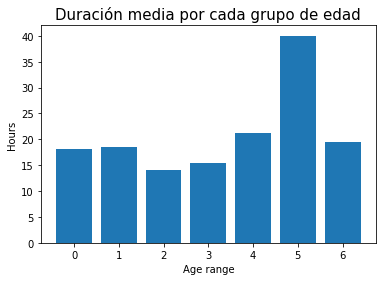

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(0,7), resultados)
plt.title('Duración media por cada grupo de edad', fontsize=15)
plt.xlabel('Age range')
plt.ylabel('Hours')

# **3**.Relación entre la duración de los trayectos y la franja horaria.
Para este apartado vamos a estudiar la duración de los trayectos respecto a la franja horaria. Lo primero es conseguir los datos de las franjas horarias y el día de la semana.

In [ ]:
def obtener_dia_hora(linea):
    datos = json.loads(linea)
    datos['unplug_hourTime'] = datetime.strptime(datos['unplug_hourTime'], "%Y-%m-%dT%H:%M:%SZ")
    datos['day']= datos['unplug_hourTime'].isoweekday()
    datos['hour'] = datos['unplug_hourTime'].hour
    return datos

In [ ]:
rdd_dia_hora= sc.textFile(filename).map(obtener_dia_hora)
df_dia_hora= spark.createDataFrame(rdd_dia_hora).drop('_id').drop('idplug_station').drop('idunplug_station').drop('idplug_base').drop('idunplug_base').drop('user_day_code').drop('user_type').drop('zip_code')
# df_dia_hora.show()

Realizamos unos histogramas que muestran el numero de trayectos realizados según las franjas horarias:

* Madrugada: 00:00 - 06:00
* Mañana: 07:00 - 13:00
* Tarde: 14:00 - 19:00
* Noche: 20:00 - 24:00

Definimos un data frame por cada una de las franjas y obtenemos los viajes que se realizan entre esas horas.



In [ ]:
df_contar_hora = df_dia_hora.groupBy('hour').count()

f_horaria = [0,7,14,20,24]
franjas = ['madrugada','mañana','tarde','noche']

In [ ]:
def obtener_franja_horaria(df,hora_p,hora_s):
    df_hora = df.filter(df['hour']>= hora_p).filter(df['hour']< hora_s).sort(df['hour'])
    return df_hora

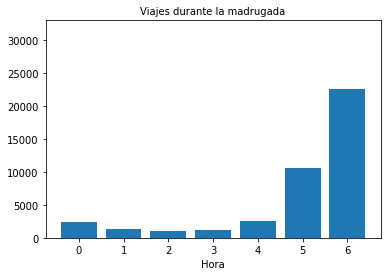

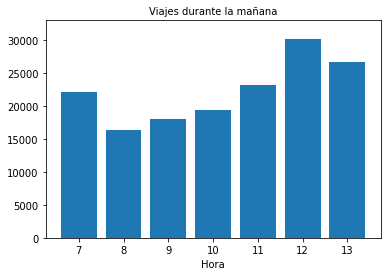

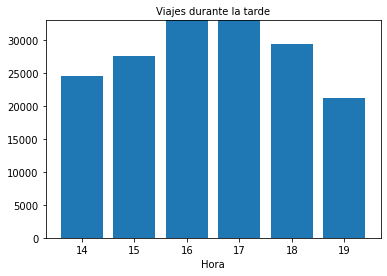

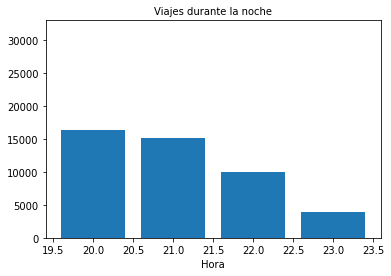

In [ ]:
for i in range(len(f_horaria)-1):
    df_franjas = obtener_franja_horaria(df_contar_hora, f_horaria[i], f_horaria[i+1])
    
    #Histograma:
    viajes = df_franjas.select("count").rdd.flatMap(lambda x: x).collect()
    plt.bar(range(f_horaria[i],f_horaria[i+1]), viajes)
    plt.title('Viajes durante la '+ franjas[i], fontsize= 10)
    plt.ylim(0,33000)
    plt.xlabel('Hora')
    plt.show()

Los histogramas nos muestran como entre las 6 y las 7 de la madrugada se eleva drásticamente el uso de las bicicletas y se mantiene durante la mañana. Se vuelve a tener otro pico entre las 16 y 18 horas y va descendiendo a lo largo de la noche.
Vamos a calcular las franjas horarias donde se producen los picos máximo y minimo del uso de las biciletas:

In [ ]:
def obtener_hora_max(df,variable):
    max_ = df.rdd.map(lambda x: x['count']).max()
    df_max = df.filter(df['count']== max_)
    df_max.show()
    maxi_frecuencia = df_max.rdd.map( lambda x: x[variable]).collect()
    return (max_, maxi_frecuencia)

def obtener_hora_min(df,variable):
    min_ = df.rdd.map(lambda x: x['count']).min()
    df_min = df.filter(df['count']==min_)
    df_min.show()
    mini_frecuencia = df_min.rdd.map(lambda x: x[variable]).collect()
    return  (min_, mini_frecuencia)

In [ ]:
(maximo,hora_max) = obtener_hora_max(df_contar_hora, 'hour')
print('La mayor cantidad de trayectos se realizan a las:', hora_max[0], 'horas, y', maximo, 'es el total de viajes.')
(minimo,hora_min) = obtener_hora_min(df_contar_hora, 'hour')
print('La menor cantidad de trayectos se realizan a las:', hora_min[0], 'horas, y', minimo, 'es el total de viajes.')


+----+-----+
|hour|count|
+----+-----+
|  17|34447|
+----+-----+

La mayor cantidad de trayectos se realizan a las: 17 horas, y 34447 es el total de viajes.
+----+-----+
|hour|count|
+----+-----+
|   2| 1079|
+----+-----+

La menor cantidad de trayectos se realizan a las: 2 horas, y 1079 es el total de viajes.


Estos resultados concuerdan con nuestras conclusiones anteriores: se produce un pico máximo a las 17h y un mínimo a las 2 de la madrugada. Hay una diferencia de 33368 viajes entre el máximo y el mínimo.

Como segunda parte de este análisis, vamos a calcular la duración media de los trayectos en las distintas franjas hotarias:

La duración media de los viajes realizados entre las 0 y las 7  es de: 18.45613049218924 minutos.
La duración media de los viajes realizados entre las 7 y las 14  es de: 28.130167471220894 minutos.
La duración media de los viajes realizados entre las 14 y las 20  es de: 20.030303872304998 minutos.
La duración media de los viajes realizados entre las 20 y las 24  es de: 17.285681826524243 minutos.


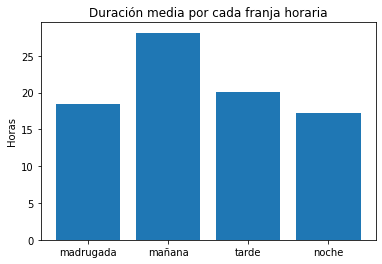

In [ ]:
duracion_media_franja = []
for i in range(len(f_horaria)-1):
    df_hora_i = obtener_franja_horaria(df_dia_hora, f_horaria[i], f_horaria[i+1])
    media_i = obtener_duracion_media(df_hora_i)
    duracion_media_franja.append(media_i)
    print('La duración media de los viajes realizados entre las', f_horaria[i], 'y las', f_horaria[i+1], ' es de:', media_i, 'minutos.')
    
#Histograma:
plt.bar(franjas, duracion_media_franja)
plt.title('Duración media por cada franja horaria')
plt.ylabel('Horas')
plt.show()



Para este estudio obtenemos que los viajes de más tiempo ocurren durante la mañana. Veamos más detalladamente que ocurre durante las 7 y las 14 horas del día:

In [ ]:
# Estudio de la duración de los viajes en la mañana
def obtener_horas_manana(df, hora):
    df_hora = df.filter(df['hour'] == hora)
    return df_hora

for i in range(f_horaria[1], f_horaria[2]):
    df_hora_i = obtener_horas_manana(df_dia_hora, i)
    duracion_media_hora_i = obtener_duracion_media(df_hora_i)
    print('La duración media de los viajes a las', i, 'horas es de: ', duracion_media_hora_i, 'minutos.')

La duración media de los viajes a las 7 horas es de:  28.28137188668198 minutos.
La duración media de los viajes a las 8 horas es de:  41.84275969656185 minutos.
La duración media de los viajes a las 9 horas es de:  34.595880035512145 minutos.
La duración media de los viajes a las 10 horas es de:  39.58390361985493 minutos.
La duración media de los viajes a las 11 horas es de:  30.349296513466125 minutos.
La duración media de los viajes a las 12 horas es de:  16.66861936466925 minutos.
La duración media de los viajes a las 13 horas es de:  17.971974693347324 minutos.


La duración de los viajes es mayor entre las 8 y 9, y desciende más rápidamente a partir de las 12 del mediodía, posiblemente debido a un aumento de las temperaturas a partir de esa hora.

# **4**.Relación entre la duración de los trayectos y la franja semanal.

Repetimos el proceso, pero para unas nuevas franjas. Esta vez tomaremos dos franjas semanales: los días laborables y los fines de semana.

In [ ]:
def obtener_franja_semanal(df,dia):
    if dia == 'laborable':
        df_semana = df.filter(df['day']<6).sort(df['day'])
    else:
        df_semana = df.filter(df['day']>5).sort(df['day'])
    return df_semana

Obtenemos un data frame para los dias laborables (lunes a viernes) y otro para los fines de semana (sábados y domingos), y los viajes que se realizan en cada una de las franjas.

In [ ]:
df_contar_dia = df_dia_hora.groupBy('day').count()

#De lunes a viernes
df_laborable = df_contar_dia.filter(df_contar_dia['day'] < 6).sort(df_contar_dia['day'])
df_laborable.show()

+---+-----+
|day|count|
+---+-----+
|  1|61802|
|  2|59271|
|  3|61646|
|  4|63550|
|  5|64709|
+---+-----+



In [ ]:
#Sábados y domingos
df_finde = df_contar_dia.filter(df_contar_dia['day'] > 5).sort(df_contar_dia['day'])
df_finde.show()

+---+-----+
|day|count|
+---+-----+
|  6|57938|
|  7|45333|
+---+-----+



Como podemos observar en fin de semana se produce una bajada en el uso de las bicicletas siendo el viernes el dia don de se produce un máximo en los viajes y el domingo el día donde se produce el mínimo.

Calculamos la duración media de los trayectos para estas franjas:

In [ ]:
#Duracion de los viajes en días laborables
df_LV = obtener_franja_semanal(df_dia_hora, 'laborable')
duracion_media_laborable = obtener_duracion_media(df_LV)
print('La duración media de los viajes de lunes a viernes es ', duracion_media_laborable, ' minutos.')

#Duracion de los viajes en fin de semana
df_SD = obtener_franja_semanal(df_dia_hora, 'finde')
duracion_media_finde = obtener_duracion_media(df_SD)
print('La duración media de los viajes los fines de semana es ',  duracion_media_finde, ' minutos.')


La duración media de los viajes de lunes a viernes es  20.64112504207157  minutos.
La duración media de los viajes los fines de semana es  28.57995920119556  minutos.


Por tanto, a pesar de que en fin de semana se producen menos viajes, la duración de los mismos es más alta en comparación con los días laborables.